# 01 - Análise de Estabelecimentos (Silver Layer)

Este notebook lê dados da camada Bronze, aplica transformações e salva na camada Silver.

**Fluxo:**
- **Bronze → Silver**: Limpeza, filtros e transformações
- **Output**: Dados curados prontos para análise

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count as spark_count, when
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Criar sessão Spark
spark = SparkSession.builder \
    .appName("Business Analysis - Silver Layer") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark version: {spark.version}")

✅ Spark version: 3.5.0


In [3]:
# Configuração de caminhos
BASE_PATH = '/home/jovyan/work'
DATA_PATH = f'{BASE_PATH}/data'
BRONZE_PATH = f'{DATA_PATH}/bronze'
SILVER_PATH = f'{DATA_PATH}/silver'

print(f"🥉 Camada Bronze: {BRONZE_PATH}")
print(f"🥈 Camada Silver: {SILVER_PATH}")

🥉 Camada Bronze: /home/jovyan/work/data/bronze
🥈 Camada Silver: /home/jovyan/work/data/silver


In [4]:

print("📥 Lendo dados da camada Bronze...\n")

df_business = spark.read.parquet(f"{BRONZE_PATH}/business")

print(f"✅ Total de registros: {df_business.count():,}")
print(f"📋 Colunas: {df_business.columns}")

📥 Lendo dados da camada Bronze...

✅ Total de registros: 150,346
📋 Colunas: ['address', 'attributes', 'business_id', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state']


In [8]:
df_business.show().vertical()

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|       120 W Main St|{NULL, NULL, NULL...|xKoz9eM8hUELf5qix...|Home & Garden, Ho...|  Plainfield|{10:0-18:0, NULL,...|      1|    39.703082|    -86.4027716|African Plum Home...|      46168|           5|  4.5|   IN|
| 2224 E Fletcher Ave|{NULL, NULL, u'no...|yiE_Iym7A9wa6tyJH...|Cheesesteaks, Bub...|       Tampa|{11:0-23:0, NULL,...|      1|   28.069

AttributeError: 'NoneType' object has no attribute 'vertical'

In [13]:

exprs = [spark_count(when(col(c).isNull(), c)).alias(c) for c in df_business.columns]


df_business.select(exprs).show(vertical=True)

-RECORD 0-------------
 address      | 0     
 attributes   | 13744 
 business_id  | 0     
 categories   | 103   
 city         | 0     
 hours        | 23223 
 is_open      | 0     
 latitude     | 0     
 longitude    | 0     
 name         | 0     
 postal_code  | 0     
 review_count | 0     
 stars        | 0     
 state        | 0     



In [14]:

print("🔧 Aplicando transformações...\n")

cols_essenciais = [
    'business_id',
    'name',
    'city',
    'categories',
    'stars',
    'review_count',
    'is_open'
]

business_clean = df_business.select(cols_essenciais) \
    .filter(col('is_open') == 1) \
    .filter(col('review_count') >= 5) \
    .filter(col('categories').isNotNull()) \
    .dropna(subset=['categories'])

print(f"✅ Registros após filtros: {business_clean.count():,}")

🔧 Aplicando transformações...

✅ Registros após filtros: 119,603


In [16]:

exprs = [spark_count(when(col(c).isNull(), c)).alias(c) for c in business_clean.columns]


business_clean.select(exprs).show(vertical=True)

-RECORD 0-----------
 business_id  | 0   
 name         | 0   
 city         | 0   
 categories   | 0   
 stars        | 0   
 review_count | 0   
 is_open      | 0   



In [17]:
# ANÁLISE: Top 15 Cidades
TOP_N_CITIES = 15

top_cities_df = business_clean.groupBy('city') \
    .agg(spark_count('*').alias('count')) \
    .orderBy(col('count').desc()) \
    .limit(TOP_N_CITIES)

print("\n🏙️ TOP 15 CIDADES:")
top_cities_df.show(15, truncate=False)

top_cities_list = [row['city'] for row in top_cities_df.collect()]


🏙️ TOP 15 CIDADES:
+----------------+-----+
|city            |count|
+----------------+-----+
|Philadelphia    |10535|
|Tucson          |7528 |
|Tampa           |7212 |
|Indianapolis    |5891 |
|Nashville       |5396 |
|Reno            |4757 |
|New Orleans     |4648 |
|Edmonton        |3915 |
|Saint Louis     |3400 |
|Santa Barbara   |3019 |
|Boise           |2458 |
|Clearwater      |1815 |
|Sparks          |1375 |
|Saint Petersburg|1364 |
|Metairie        |1332 |
+----------------+-----+



In [18]:

city_restaurants = business_clean.filter(col('city').isin(top_cities_list))

total_records = city_restaurants.count()
print(f"\n✅ Total de restaurantes nas top {TOP_N_CITIES} cidades: {total_records:,}")

print("\n📊 Estatísticas:")
city_restaurants.select('stars', 'review_count').describe().show()


✅ Total de restaurantes nas top 15 cidades: 64,645

📊 Estatísticas:
+-------+------------------+-----------------+
|summary|             stars|     review_count|
+-------+------------------+-----------------+
|  count|             64645|            64645|
|   mean|3.6732229870833013|57.17398097300642|
| stddev|0.9957115908529536|165.6181765227344|
|    min|               1.0|                5|
|    max|               5.0|             7568|
+-------+------------------+-----------------+



📊 Gerando visualizações...



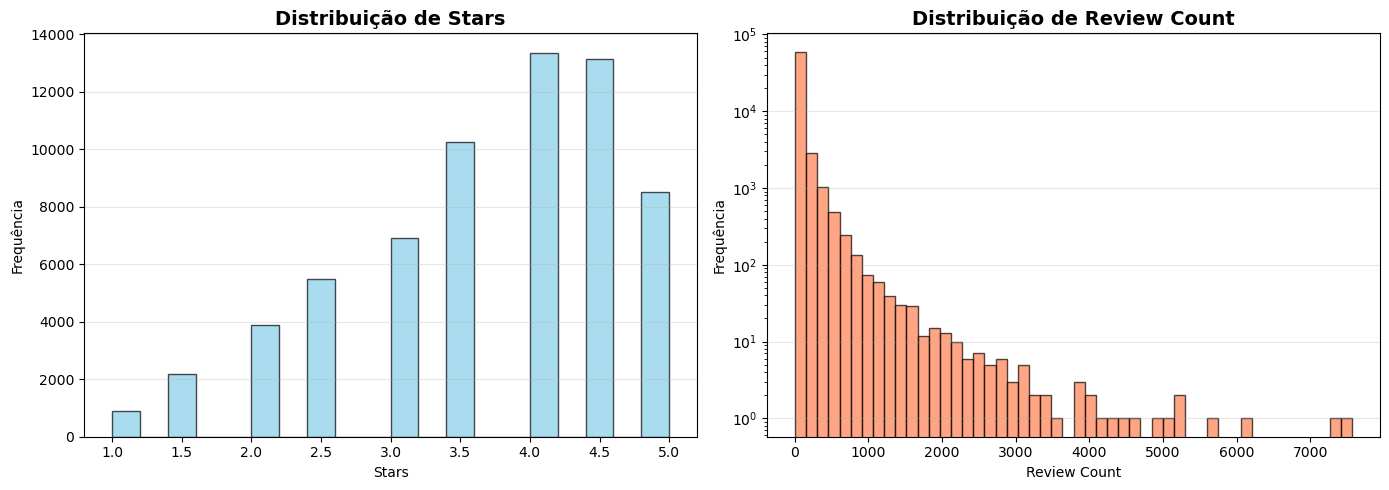

✅ Visualizações geradas!


In [19]:

print("📊 Gerando visualizações...\n")

df_plot = city_restaurants.select('stars', 'review_count').toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(df_plot['stars'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição de Stars', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stars')
axes[0].set_ylabel('Frequência')
axes[0].grid(axis='y', alpha=0.3)


axes[1].hist(df_plot['review_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribuição de Review Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Review Count')
axes[1].set_ylabel('Frequência')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Visualizações geradas!")

In [26]:
from pyspark.sql import functions as F



df_final = city_restaurants.withColumn("log_review_count", F.log1p("review_count")) \
             .drop("review_count")

df_final.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- is_open: long (nullable = true)
 |-- log_review_count: double (nullable = true)



In [27]:
df_final.show()

+--------------------+--------------------+------------+--------------------+-----+-------+------------------+
|         business_id|                name|        city|          categories|stars|is_open|  log_review_count|
+--------------------+--------------------+------------+--------------------+-----+-------+------------------+
|yiE_Iym7A9wa6tyJH...|      Craft Fry Wing|       Tampa|Cheesesteaks, Bub...|  4.5|      1| 3.784189633918261|
|7d9X9wnm_35UcdJRJ...|          China King|Indianapolis|Restaurants, Chinese|  4.0|      1|3.1354942159291497|
|CFPWVAFSP3Ktfe-cE...|Liberty Real Esta...|Philadelphia|Home Services, Re...|  1.5|      1| 2.772588722239781|
|b3KxHgc7le1Mc2Q3O...|    Flowers By Merle|    Edmonton|Flowers & Gifts, ...|  3.5|      1| 2.833213344056216|
|2tAi411srrpmMofeA...|Just Breakfast on...|      Tucson|Coffee & Tea, Bre...|  3.5|      1| 4.736198448394496|
|dN2whsRNU90vPfocj...|Baltimore Pet Shoppe|Philadelphia|    Pet Stores, Pets|  4.5|      1| 4.110873864173311|
|

In [28]:

print("💾 Salvando dados na camada Silver...\n")

output_path = f'{SILVER_PATH}/business'

df_final.write \
    .mode('overwrite') \
    .parquet(output_path)

print(f"✅ Dados salvos em: {output_path}")
print(f"📊 Total de registros: {total_records:,}")

💾 Salvando dados na camada Silver...

✅ Dados salvos em: /home/jovyan/work/data/silver/business
📊 Total de registros: 64,645


In [29]:

print("\n" + "="*70)
print("📊 RESUMO DA ANÁLISE DE BUSINESS")
print("="*70)
print(f"\n📥 Dados lidos da Bronze Layer: {BRONZE_PATH}/business")
print(f"🔧 Filtros aplicados:")
print(f"   - Apenas estabelecimentos abertos (is_open = 1)")
print(f"   - Mínimo de 5 reviews")
print(f"   - Com categorias definidas")
print(f"\n🏙️ Top {TOP_N_CITIES} cidades selecionadas")
print(f"📊 Total de estabelecimentos: {total_records:,}")
print(f"\n💾 Dados salvos na Silver Layer: {output_path}")
print(f"\n✅ Análise concluída!")


📊 RESUMO DA ANÁLISE DE BUSINESS

📥 Dados lidos da Bronze Layer: /home/jovyan/work/data/bronze/business
🔧 Filtros aplicados:
   - Apenas estabelecimentos abertos (is_open = 1)
   - Mínimo de 5 reviews
   - Com categorias definidas

🏙️ Top 15 cidades selecionadas
📊 Total de estabelecimentos: 64,645

💾 Dados salvos na Silver Layer: /home/jovyan/work/data/silver/business

✅ Análise concluída!


In [ ]:
spark.stop()
print("\n💡 Próximos passos:")
print("   - Execute 02_reviews_analysis.ipynb para análise de reviews")
print("   - Os dados processados estão na camada Silver")